In [30]:
import data_preprocessing_cleaned as clean

def clean_data(csv_file:str): 
    df = clean.TweetCleaner(csv_file)
    cleaned_df = df.clean_tweets()
    cleaned_df['preprocessed_text'] = cleaned_df['cleaned_text'].apply(preprocess_text_lemmatization)
    return cleaned_df

In [33]:
#nltk.download('wordnet')
df = clean_data('twitter_data.csv')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alan\AppData\Roaming\nltk_data...


In [41]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

def preprocess(text):
    stop_words = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    tokens = tokenizer.tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 1]
    return tokens

df['processed_text'] = df['cleaned_text'].apply(preprocess)

In [42]:
df

,Unnamed: 0,hashed_userid,masked_username,location,following,followers,totaltweets,usercreateddt,tweetid,tweetcreatedts,...,favorite_count,is_retweet,original_tweet_id,in_reply_to_status_id,is_quote_status,quoted_status_id,extractedts,cleaned_text,preprocessed_text,processed_text
0,0,13028308852725196659,*****roy1,NaN,9590,8725,29317,2012-01-24,1542763288815030273,2022-07-01 06:53:25,...,0,True,1542689411489337344,0,False,0,2022-07-01 12:03:31.185425,for 49 years libertys torch shone to ensure ba...,49 year liberty torch shone ensure basic human...,"[49, year, liberty, torch, shone, ensure, basi..."
1,1,45494576030177085457,******eam_6,NaN,8874,10090,33053,2019-02-07,1542763315926994945,2022-07-01 06:53:32,...,0,True,1542689411489337344,0,False,0,2022-07-01 12:03:31.171429,for 49 years libertys torch shone to ensure ba...,49 year liberty torch shone ensure basic human...,"[49, year, liberty, torch, shone, ensure, basi..."
2,2,23641094384211702614,******erlin,"Los Angeles, CA",7730,10006,35360,2008-08-07,1542763330670014464,2022-07-01 06:53:35,...,0,True,1542689411489337344,0,False,0,2022-07-01 12:03:31.157331,for 49 years libertys torch shone to ensure ba...,49 year liberty torch shone ensure basic human...,"[49, year, liberty, torch, shone, ensure, basi..."
3,3,21587659761682762378,******oshi23,Mumbai,232,132,4970,2016-05-10,1542763339738382337,2022-07-01 06:53:38,...,0,True,1542707138971242496,0,False,0,2022-07-01 12:03:31.123276,home based church are now everywhere in punjab...,home based church everywhere punjab haryana ev...,"[home, based, church, everywhere, punjab, hary..."
4,4,47915146590553055505,******4Truth,NaN,6914,6310,49958,2021-04-02,1542763352279003136,2022-07-01 06:53:40,...,0,True,1542689411489337344,0,False,0,2022-07-01 12:03:31.097582,for 49 years libertys torch shone to ensure ba...,49 year liberty torch shone ensure basic human...,"[49, year, liberty, torch, shone, ensure, basi..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415367,415367,83242079331442835051,*******tresist,NaN,257,758,272531,2017-02-16,1560822761706094592,2022-08-20 02:55:19,...,0,True,1560794896663203840,0,False,0,2022-08-20 02:58:51.096736,15 adds,15 add,"[15, add]"
415368,415368,98949018742144878760,*****ll42,NaN,603,179,59766,2014-03-14,1560822898780213249,2022-08-20 02:55:52,...,0,True,1560750229720563712,0,False,0,2022-08-20 02:58:51.087505,no to against every single republican,every single republican,"[every, single, republican]"
415369,415369,42256911176251501556,*******eDuster,Chi-town,416,8852,11699,2009-03-26,1560823151671488513,2022-08-20 02:56:52,...,0,True,1560280488488718336,0,False,0,2022-08-20 02:58:51.077181,the 19th amendment was ratified in 1920 granti...,19th amendment ratified 1920 granting woman ri...,"[19th, amendment, ratified, 1920, granting, wo..."
415370,415370,95273352056344375133,*****kh59,"Terre Haute, IN",854,298,16999,2017-10-10,1560823347583361024,2022-08-20 02:57:39,...,0,False,0,1560769551347900416,False,0,2022-08-20 02:58:51.066790,yes we are not happy we are angry,yes happy angry,"[yes, happy, angry]"


In [43]:
from gensim.corpora import Dictionary

# Create a Gensim dictionary from the processed text
dictionary = Dictionary(df['processed_text'])

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Create a corpus: a list of bag of words for each document
corpus = [dictionary.doc2bow(doc) for doc in df['processed_text']]


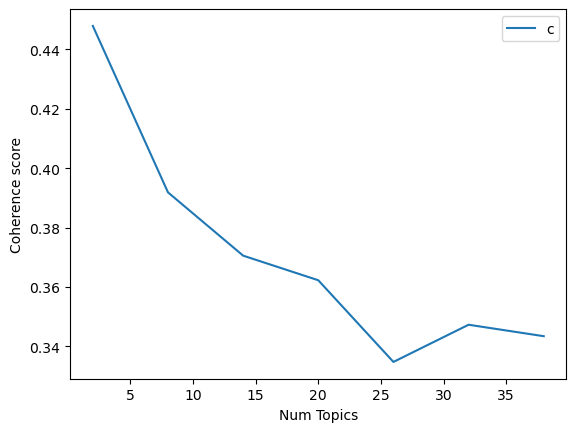

In [44]:
# find optimal number of topics

from gensim.models.coherencemodel import CoherenceModel

# Function to compute coherence values for different number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Use this function to find the optimal number of topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=df['processed_text'].tolist(), start=2, limit=40, step=6)

# Plotting
import matplotlib.pyplot as plt

x = range(2, 40, 6)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [45]:
# Apply LDA
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)



(0, '0.035*"year" + 0.026*"go" + 0.026*"please" + 0.025*"thing" + 0.025*"friend"')
(1, '0.097*"amp" + 0.049*"abortion" + 0.031*"need" + 0.029*"say" + 0.024*"vote"')
(2, '0.067*"male" + 0.038*"decision" + 0.031*"court" + 0.029*"today" + 0.027*"one"')
(3, '0.037*"would" + 0.033*"people" + 0.029*"pregnancy" + 0.026*"never" + 0.025*"stop"')
(4, '0.099*"woman" + 0.051*"right" + 0.037*"life" + 0.033*"support" + 0.024*"female"')


In [46]:
# View the topics
topics = lda_model.print_topics(num_words=20)
for topic in topics:
    print(topic)

(0, '0.035*"year" + 0.026*"go" + 0.026*"please" + 0.025*"thing" + 0.025*"friend" + 0.025*"daughter" + 0.025*"case" + 0.025*"ever" + 0.024*"small" + 0.023*"speak" + 0.023*"storm" + 0.022*"package" + 0.022*"ordered" + 0.022*"bathroom" + 0.021*"weather" + 0.021*"publicly" + 0.021*"228" + 0.021*"shelf" + 0.018*"cabinet" + 0.013*"like"')
(1, '0.097*"amp" + 0.049*"abortion" + 0.031*"need" + 0.029*"say" + 0.024*"vote" + 0.021*"era" + 0.020*"everywhere" + 0.020*"state" + 0.017*"make" + 0.010*"roe" + 0.010*"help" + 0.010*"protect" + 0.010*"care" + 0.009*"law" + 0.008*"many" + 0.008*"back" + 0.008*"november" + 0.008*"work" + 0.008*"new" + 0.007*"every"')
(2, '0.067*"male" + 0.038*"decision" + 0.031*"court" + 0.029*"today" + 0.027*"one" + 0.019*"america" + 0.018*"health" + 0.018*"supreme" + 0.015*"keep" + 0.014*"1931" + 0.014*"read" + 0.014*"thats" + 0.013*"journalist" + 0.012*"trump" + 0.012*"story" + 0.011*"overturn" + 0.011*"amendment" + 0.011*"poll" + 0.010*"doesnt" + 0.010*"weapon"')
(3, '0.